In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
from matplotlib import cm
#from highlight_text import fig_text, ax_text
import matplotlib.gridspec as gridspec
import pylab as p
from plottable import ColumnDefinition, Table
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from plottable.cmap import normed_cmap
from plottable.plots import image
import pandas as pd
import matplotlib


from PIL import Image

from mplsoccer import FontManager
URL3 = 'https://github.com/VanillaandCream/Catamaran-Tamil/blob/master/Fonts/Catamaran-Medium.ttf?raw=true'
catamaran2 = FontManager(URL3)
URL = 'https://github.com/google/fonts/blob/main/ofl/fjallaone/FjallaOne-Regular.ttf?raw=true'
robotto_regular = FontManager(URL)
URL2 = 'https://github.com/VanillaandCream/Catamaran-Tamil/blob/master/Fonts/Catamaran-ExtraBold.ttf?raw=true'
catamaran = FontManager(URL2)

In [6]:
df = pd.read_csv('C:/Users/Federico Rábanos/Documents/lanus stats/Python/Todos los eventos CopaLPF2024 Fecha 14.csv')
df_xGs = df[['round','match_id','team','xg', 'goals']].groupby(['round','match_id', 'team'], as_index=False).sum()

In [8]:
df_xGs

,round,match_id,team,xg,goals
0,1,4393553,Defensa y Justicia,0.12,0
1,1,4393553,Godoy Cruz,1.48,2
2,1,4393554,Argentinos Juniors,0.66,1
3,1,4393554,River Plate,1.00,1
4,1,4393555,Deportivo Riestra,0.18,0
...,...,...,...,...,...
387,14,4393728,Godoy Cruz,0.86,0
388,14,4393729,Defensa y Justicia,1.90,1
389,14,4393729,Newell's Old Boys,1.29,0
390,14,4393730,Estudiantes,1.42,2


In [9]:
df_xG_tot = df_xGs.merge(df_xGs, how='inner', on='match_id', suffixes=('', '_other'))
df_xG_tot['xga'] = df_xG_tot['xg_other']
df_xG_tot.drop(['round_other', 'team_other', 'xg_other'], axis=1).drop_duplicates(subset=['match_id', 'team', 'xg', 'xga'])

,round,match_id,team,xg,xga
0,1,4393553,Defensa y Justicia,0.12,0.12
1,1,4393553,Defensa y Justicia,0.12,1.48
2,1,4393553,Godoy Cruz,1.48,0.12
3,1,4393553,Godoy Cruz,1.48,1.48
4,1,4393554,Argentinos Juniors,0.66,0.66
...,...,...,...,...,...
779,14,4393729,Newell's Old Boys,1.29,1.29
780,14,4393730,Estudiantes,1.42,1.42
781,14,4393730,Estudiantes,1.42,1.05
782,14,4393730,Lanus,1.05,1.42


In [12]:
merged_df = df_xGs.merge(df_xGs, how='inner', on='match_id', suffixes=('', '_other'))
merged_df['xga'] = merged_df['xg_other']
merged_df.drop(['round_other', 'xg_other', 'goals_other'], axis=1, inplace=True)

# Eliminar filas duplicadas
result_df = merged_df[merged_df['team'] != merged_df['team_other']]
result_df = result_df.drop_duplicates(subset=['match_id', 'team'])

# Limpiar y mostrar el resultado
result_df.drop(['team_other'], axis=1, inplace=True)
result_df = result_df.reset_index(drop=True)

In [13]:
df_xG_tot = result_df

In [14]:
df_xG_tot.columns

Index(['round', 'match_id', 'team', 'xg', 'goals', 'xga'], dtype='object')

In [15]:
df_xG_tot

,round,match_id,team,xg,goals,xga
0,1,4393553,Defensa y Justicia,0.12,0,1.48
1,1,4393553,Godoy Cruz,1.48,2,0.12
2,1,4393554,Argentinos Juniors,0.66,1,1.00
3,1,4393554,River Plate,1.00,1,0.66
4,1,4393555,Deportivo Riestra,0.18,0,0.52
...,...,...,...,...,...,...
387,14,4393728,Godoy Cruz,0.86,0,0.63
388,14,4393729,Defensa y Justicia,1.90,1,1.29
389,14,4393729,Newell's Old Boys,1.29,0,1.90
390,14,4393730,Estudiantes,1.42,2,1.05


In [100]:
def get_xG_rolling_data(team_id, window=10, data=df_xG_tot):
    '''
    This function returns xG rolling average figures for a specific team.
    '''
    df_roll = data.copy()
    df_roll = df_roll[df_roll['team'] == team_id].reset_index(drop=True)
    df_roll['rolling_xG_corr'] = df_roll['xg'].rolling(window, min_periods=0).mean()
    df_roll['rolling_xG_ag'] = df_roll['xga'].rolling(window, min_periods=0).mean()
    df_roll['rolling_diff'] = df_roll['rolling_xG_corr'] - df_roll['rolling_xG_ag']
    return df_roll

def get_xG_interpolated_df(team_id, window=10, data=df_xG_tot):
    # --- Get the xG rolling df
    df_xG = get_xG_rolling_data(team_id, window, data)
    # -- Create interpolated series
    df_xG['match_number'] = df_xG.index
    X_aux = df_xG.match_number.copy()
    X_aux.index = X_aux * 10 # 9 aux points in between each match
    last_idx = X_aux.index[-1] + 1
    X_aux = X_aux.reindex(range(last_idx))
    X_aux = X_aux.interpolate()
    # --- Aux series for the xG created (Y_for)
    Y_for_aux = df_xG.rolling_xG_corr.copy()
    Y_for_aux.index = Y_for_aux.index * 10
    last_idx = Y_for_aux.index[-1] + 1
    Y_for_aux = Y_for_aux.reindex(range(last_idx))
    Y_for_aux = Y_for_aux.interpolate()
    # --- Aux series for the xG conceded (Y_ag)
    Y_ag_aux = df_xG.rolling_xG_ag.copy()
    Y_ag_aux.index = Y_ag_aux.index * 10
    last_idx = Y_ag_aux.index[-1] + 1
    Y_ag_aux = Y_ag_aux.reindex(range(last_idx))
    Y_ag_aux = Y_ag_aux.interpolate()
    # --- Aux series for the rolling difference in xG
    Z_diff_aux = df_xG.rolling_diff.copy()
    Z_diff_aux.index = Z_diff_aux.index * 10
    last_idx = Z_diff_aux.index[-1] + 1
    Z_diff_aux = Z_diff_aux.reindex(range(last_idx))
    Z_diff_aux = Z_diff_aux.interpolate()
    # -- Create the aux dataframe
    df_aux = pd.DataFrame({
        'X': X_aux,
        'Y_for': Y_for_aux,
        'Y_ag': Y_ag_aux,
        'Z': Z_diff_aux
    })
    return df_aux

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mcolors.to_rgb(c1))
    c2=np.array(mcolors.to_rgb(c2))
    return mcolors.to_hex((1-mix)*c1 + mix*c2)


def plot_xG_gradient(ax, team_id, window=10, data=df_xG_tot):
    # -- Get the data
    df_xg = get_xG_rolling_data(team_id, window, data)
    df_aux_xg = get_xG_interpolated_df(team_id, window, data)
    # Specify the axes limits
    ax.set_ylim(0,2)
    ax.set_xlim(-0.5,df_xg.shape[0])
    ax.grid(ls='--', color='lightgrey')
    # -- Select the colors
    color_2 = '#00ff85'
    color_1 = '#38003c'

    ax.plot(df_xg.index, df_xg['rolling_xG_corr'], color=color_2,zorder=4)
    ax.plot(df_xg.index, df_xg['rolling_xG_ag'], color=color_1,zorder=4)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.fill_between(x=[-0.5,30], y1=ax.get_ylim()[0], y2=ax.get_ylim()[1], alpha=0.1, color='black', ec='None',zorder=2)
    vmin = df_xg['rolling_diff'].min()
    vmax = df_xg['rolling_diff'].max()
    vmax = max(abs(vmin), abs(vmax))
    vmin = -1*vmax
    for i in range(0, len(df_aux_xg['X']) - 1):
        ax.fill_between(
            [df_aux_xg['X'].iloc[i], df_aux_xg['X'].iloc[i+1]],
            [df_aux_xg['Y_for'].iloc[i], df_aux_xg['Y_for'].iloc[i + 1]],
            [df_aux_xg['Y_ag'].iloc[i], df_aux_xg['Y_ag'].iloc[i + 1]],
            color=colorFader(color_1, color_2, mix=((df_aux_xg['Z'].iloc[i] - vmin)/(vmax - vmin))),
            zorder=3, alpha=0.3
        )
    for x in [38, 38*2]:
        ax.plot([x,x],[ax.get_ylim()[0], ax.get_ylim()[1]], color='black', alpha=0.35, zorder=2, ls='dashdot', lw=0.95)

    return ax

In [101]:
get_xG_rolling_data('Defensa y Justicia',5, df_xG_tot)

,round,match_id,team,xg,xga,rolling_xG_corr,rolling_xG_ag,rolling_diff
0,1,4393553,Defensa y Justicia,0.12,1.48,0.120000,1.480,-1.360000
1,2,4393714,Defensa y Justicia,1.22,0.77,0.670000,1.125,-0.455000
2,3,4393541,Defensa y Justicia,0.71,0.93,0.683333,1.060,-0.376667
3,4,4393577,Defensa y Justicia,0.25,2.04,0.575000,1.305,-0.730000
4,5,4393607,Defensa y Justicia,2.06,1.28,0.872000,1.300,-0.428000
5,6,4393582,Defensa y Justicia,0.89,1.23,1.026000,1.250,-0.224000
6,7,4393593,Defensa y Justicia,1.70,0.70,1.122000,1.236,-0.114000
7,8,4393649,Defensa y Justicia,0.67,1.80,1.114000,1.410,-0.296000
8,9,4393667,Defensa y Justicia,0.00,0.00,1.064000,1.002,0.062000
9,10,4393634,Defensa y Justicia,1.54,0.84,0.960000,0.914,0.046000


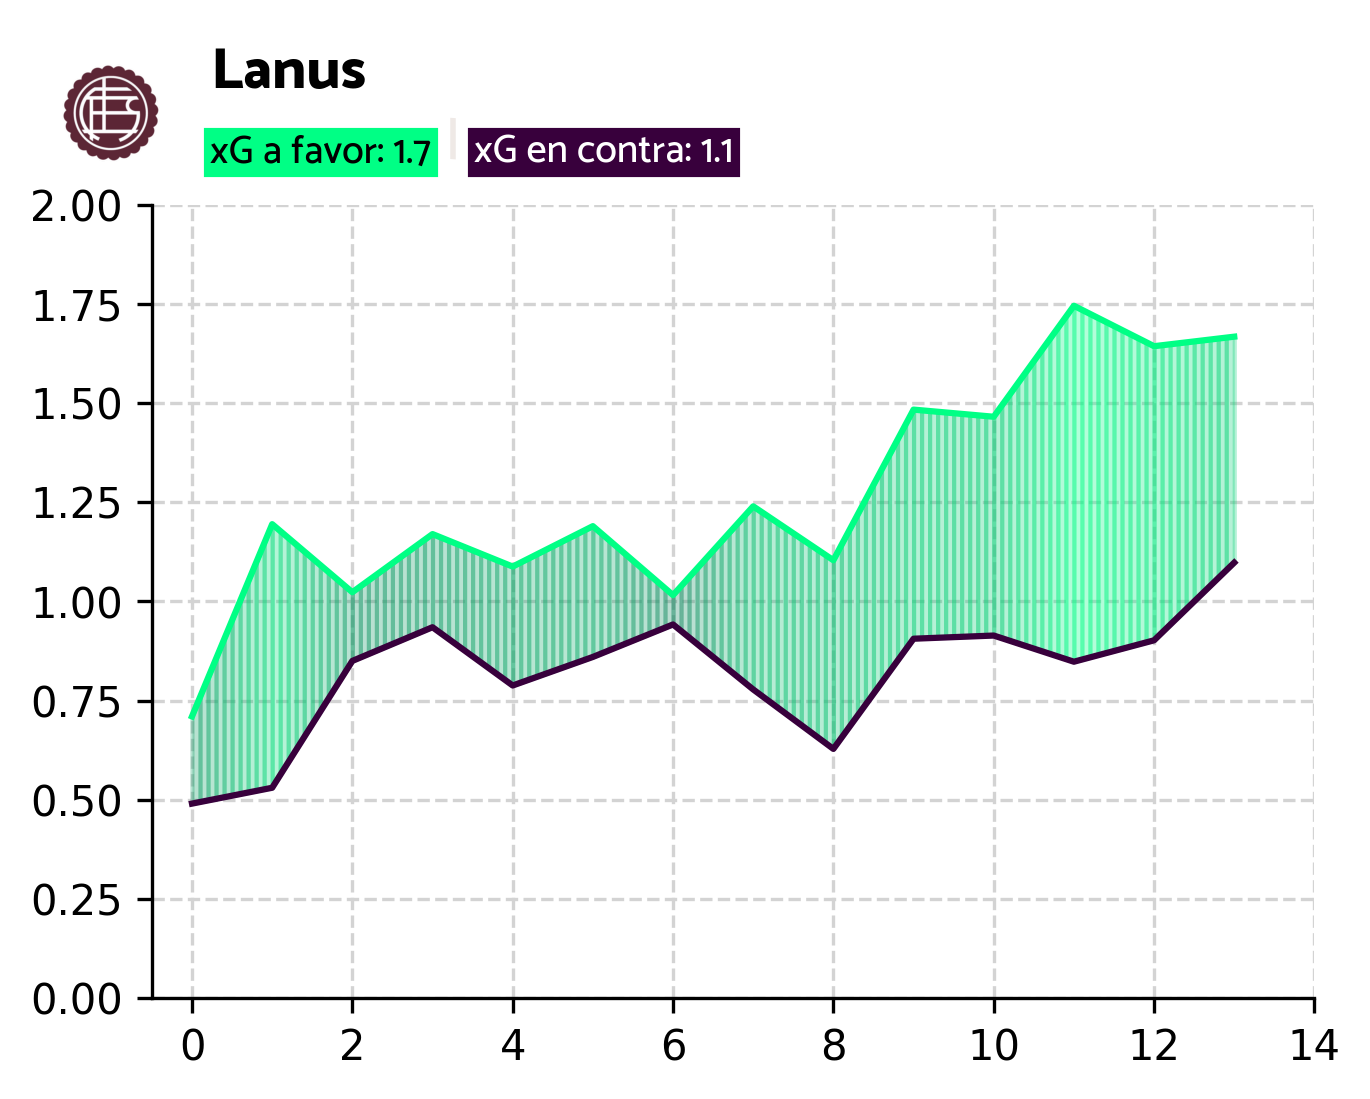

In [115]:
fig = plt.figure(figsize=(5,3.5), dpi=300)
ax = plt.subplot(111)
fig.set_facecolor('white')

teamId = 'Lanus'

plot_xG_gradient(ax, teamId, 5, df_xG_tot)
df_for_text = get_xG_rolling_data(teamId, 5)
teamName = df_for_text['team'].iloc[0]
xG_for = df_for_text['rolling_xG_corr'].iloc[-1]
xG_ag = df_for_text['rolling_xG_ag'].iloc[-1]
color_2 = '#00ff85'
color_1 = '#38003c'
# -- This was done manually cuz I'm lazy...
if color_1 == '#d1d3d4':
    color_1_t = 'black'
else:
    color_1_t = 'white'
if color_2 == '#97c1e7':
    color_2_t = 'black'
else:
    color_2_t = 'black'
                
ax_text(
                x = 0.05, 
                y = 1.2,
                s = f'<{teamName}>\n<xG a favor: {xG_for:.1f}> <|> <xG en contra: {xG_ag:.1f}>',
                ax = ax, 
                highlight_textprops=[
                    {'weight':'bold', 'font':catamaran.prop},
                    {'size':'9.5', 'bbox': {'edgecolor': color_2, 'facecolor': color_2, 'pad': 1}, 'color': color_2_t}, 
                    {'color':'#EFE9E6'},
                    {'size':'9.5', 'bbox': {'edgecolor': color_1, 'facecolor': color_1, 'pad': 1}, 'color': color_1_t}
                ],
                font = catamaran2.prop, 
                ha = 'left', 
                size = 14, 
                annotationbbox_kw = {'xycoords':'axes fraction'}
            )
logo_ax = fig.add_axes(
    [0.05, .92, .095, .095]
)
club_icon = Image.open(f'C:/Users/Federico Rábanos/Documents/lanus stats/Logos/2/{teamName.lower()}.png')
logo_ax.imshow(club_icon)
logo_ax.axis('off')

plt.savefig(
	f"C:/Users/Federico Rábanos/Documents/lanus stats/Hilos/CDLG24/rollingxgs_cdlg24_{teamName}.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

In [66]:
df_xG_tot.team.sort_values().unique()[:7]

array(['Argentinos Juniors', 'Atletico Tucuman', 'Banfield',
       'Barracas Central', 'Belgrano', 'Boca Juniors',
       'Central Cordoba de Santiago'], dtype=object)

'\nplt.savefig(\n\t"figures/09262022_epl_xG_rolling_gradient_tr.png",\n\tdpi = 600,\n\tfacecolor = "none",\n\tbbox_inches="tight",\n    edgecolor="none",\n\ttransparent = True\n)'

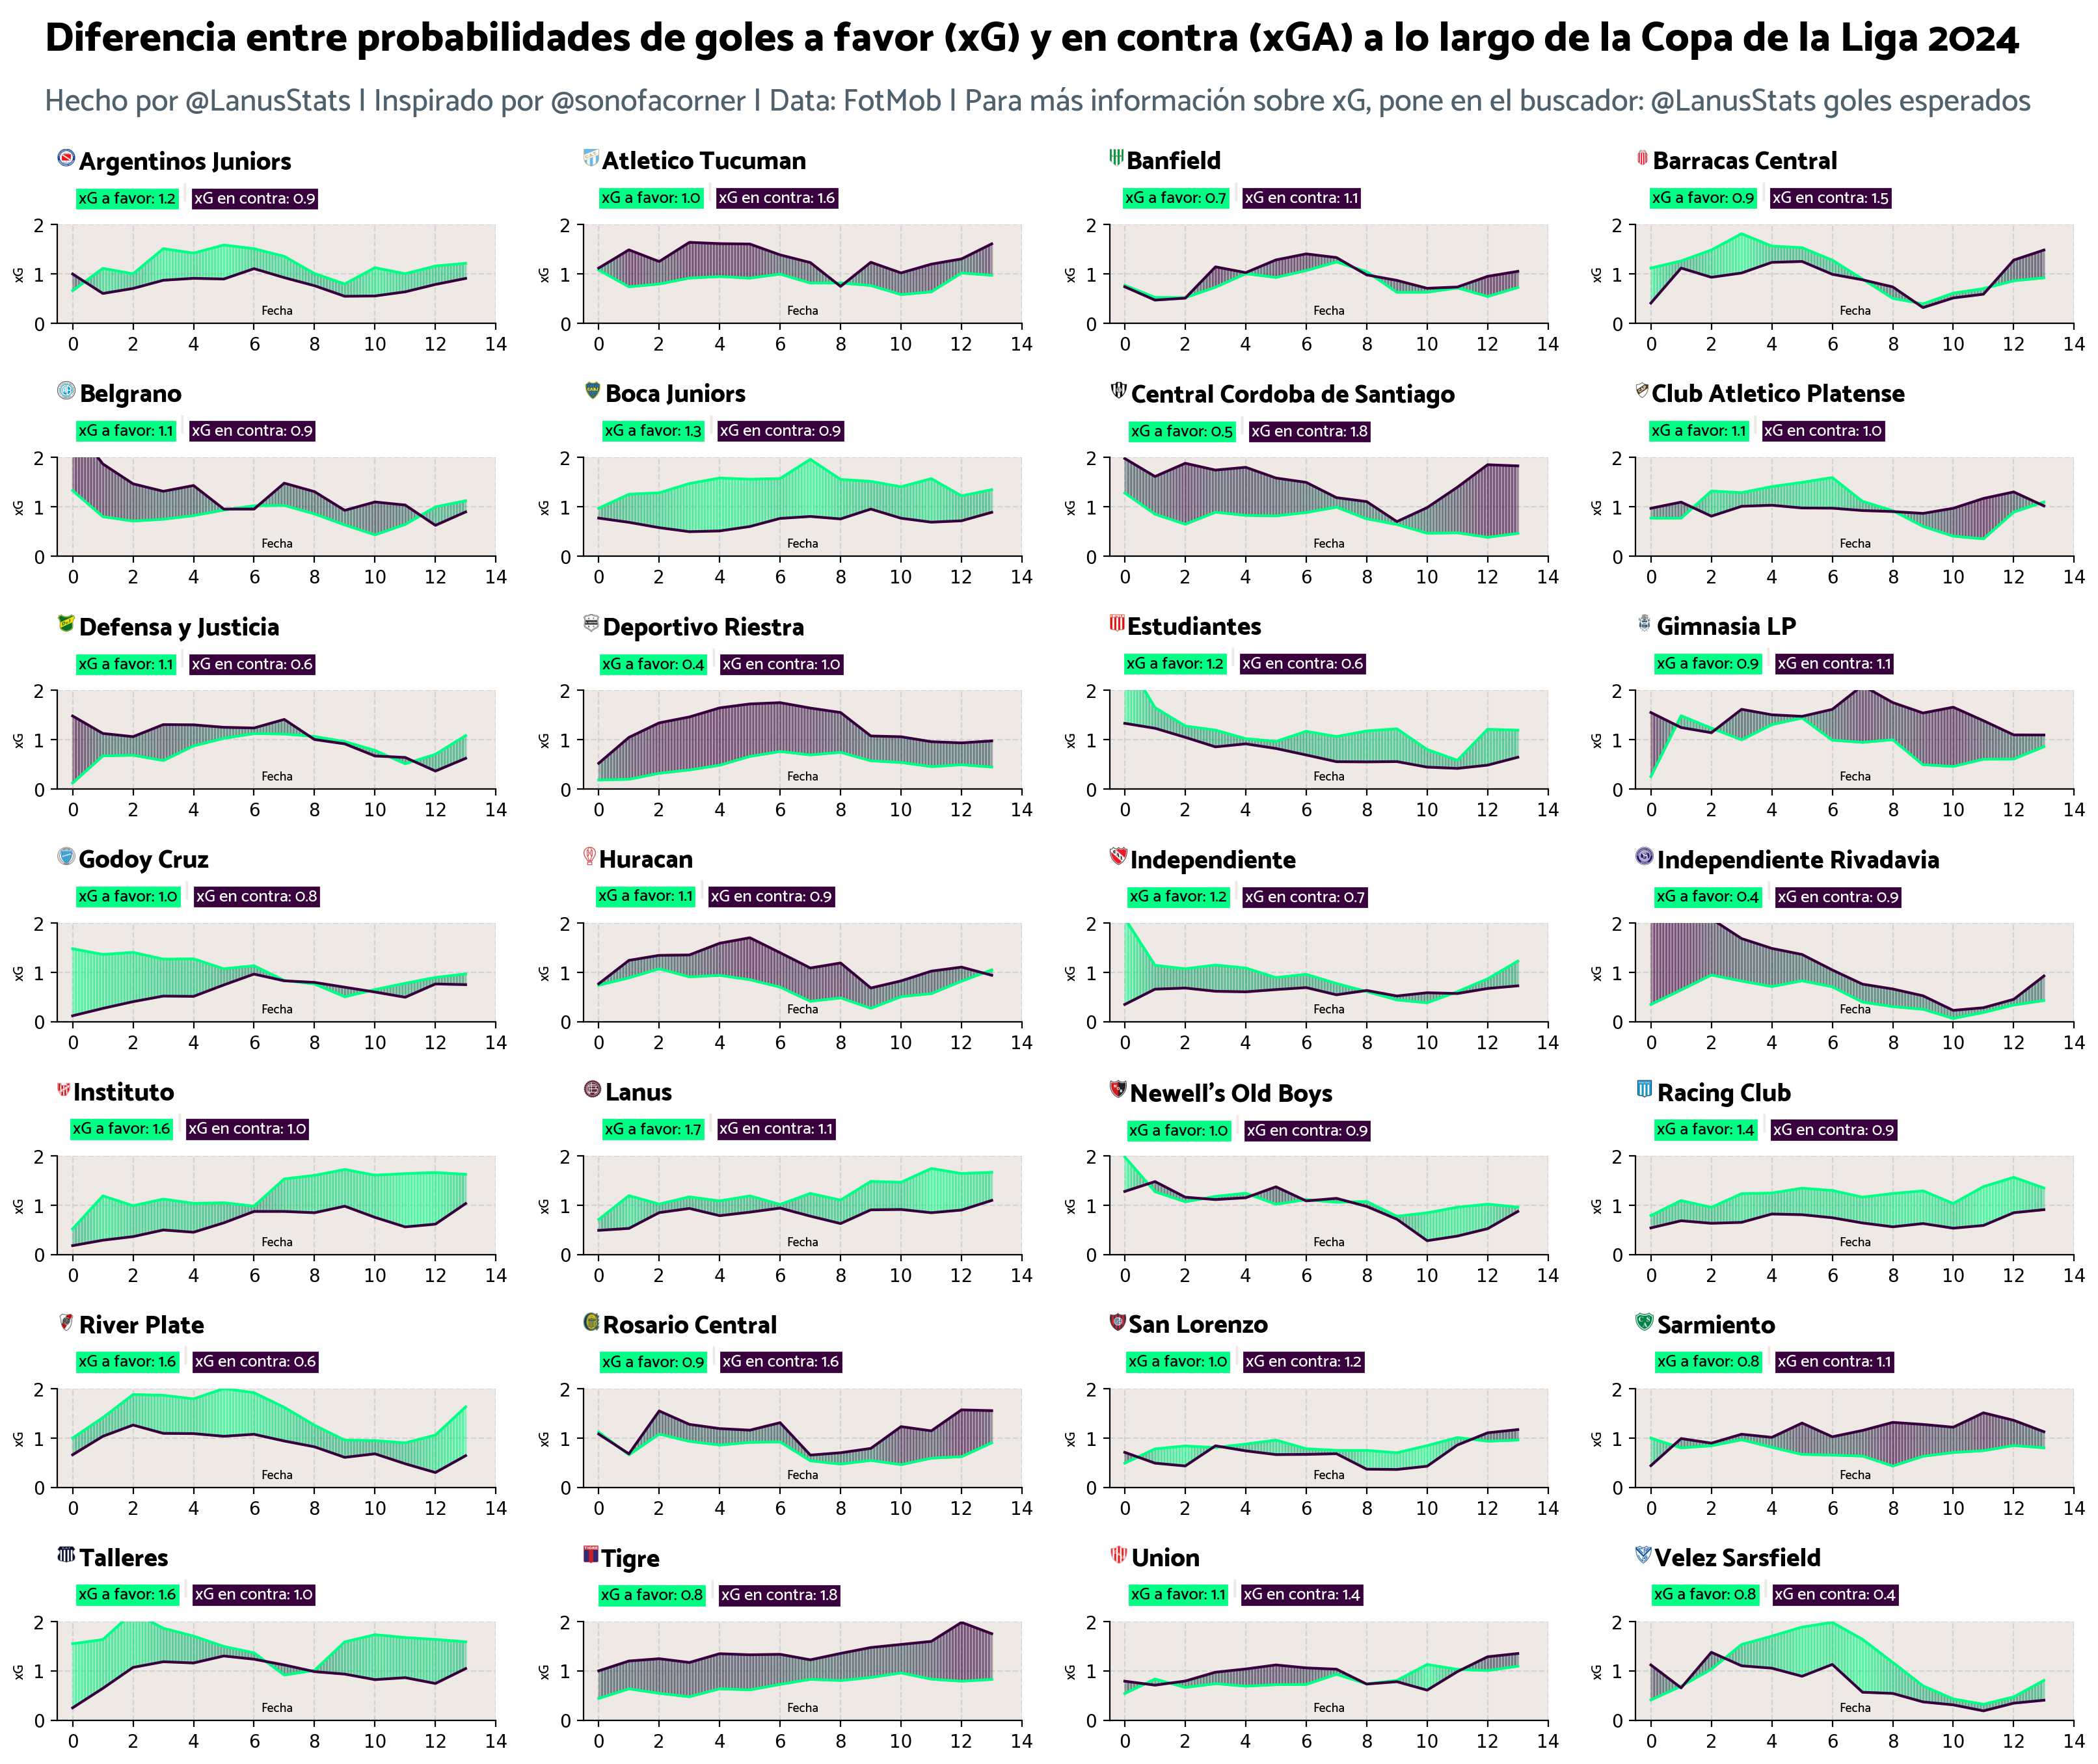

In [105]:
# ---- for path effects
def path_effect_stroke(**kwargs):
    return [path_effects.Stroke(**kwargs), path_effects.Normal()]
pe = path_effect_stroke(linewidth=1.5, foreground="black")
# ----
fig = plt.figure(figsize=(20, 16), dpi = 200)
fig.set_facecolor('white')
nrows = 14 #Numero de equipos * 2
ncols = 4
gspec = gridspec.GridSpec(
    ncols=ncols, nrows=nrows, figure=fig, 
    height_ratios=[(1/nrows)*2.35 if x % 2 != 0 else (1/nrows)/2.35 for x in range(nrows)], hspace=1
)

plot_counter = 0
logo_counter = 0

for row in range(nrows):
    for col in range(ncols):
        if row % 2 != 0: #ploteo grafico
            ax = plt.subplot(
                gspec[row, col],
                facecolor = "#EFE9E6"
            )
            teamId = list(df_xG_tot.team.sort_values().unique())[plot_counter]
            plot_xG_gradient(ax, teamId, 5)
            plt.xlabel('Fecha', size=7, fontproperties=catamaran2.prop, labelpad=-27)
            plt.ylabel('xG', size=8, fontproperties=catamaran2.prop)
                       
            plot_counter += 1
        else: #ploteo logos
            teamId = list(df_xG_tot.team.sort_values().unique())[logo_counter]
            color_2 = '#00ff85'
            color_1 = '#38003c'
            # -- This was done manually cuz I'm lazy...
            if color_1 == '#d1d3d4':
                color_1_t = 'black'
            else:
                color_1_t = 'white'
            if color_2 == '#97c1e7':
                color_2_t = 'black'
            else:
                color_2_t = 'black'
            df_for_text = get_xG_rolling_data(teamId, 5)
            teamName = df_for_text['team'].iloc[0]
            xG_for = df_for_text['rolling_xG_corr'].iloc[-1]
            xG_ag = df_for_text['rolling_xG_ag'].iloc[-1]
            #fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
            logo_ax = plt.subplot(
                gspec[row,col],
                anchor = 'NW', facecolor = '#EFE9E6'
            )
            club_icon = Image.open(f'C:/Users/Federico Rábanos/Documents/lanus stats/Logos/2/{teamName.lower()}.png')
            logo_ax.imshow(club_icon)
            logo_ax.axis('off')
            # -- Add the team name
            ax_text(
                x = 1.2, 
                y = 0.9,
                s = f'<{teamName}>\n<xG a favor: {xG_for:.1f}> <|> <xG en contra: {xG_ag:.1f}>',
                ax = logo_ax, 
                highlight_textprops=[
                    {'weight':'bold', 'font':catamaran.prop},
                    {'size':'9.5', 'bbox': {'edgecolor': color_2, 'facecolor': color_2, 'pad': 1}, 'color': color_2_t}, 
                    {'color':'#EFE9E6'},
                    {'size':'9.5', 'bbox': {'edgecolor': color_1, 'facecolor': color_1, 'pad': 1}, 'color': color_1_t}
                ],
                font = catamaran2.prop, 
                ha = 'left', 
                size = 14, 
                annotationbbox_kw = {'xycoords':'axes fraction'}
            )
            logo_counter += 1

fig_text(
    x=0.12, y=.923, 
    s='Diferencia entre probabilidades de goles a favor (xG) y en contra (xGA) a lo largo de la Copa de la Liga 2024',
    va='bottom', ha='left',  fontproperties=catamaran.prop,
    fontsize=23, color='black'
)
fig_text(
	x=0.12, y=.895, 
    s='Hecho por @LanusStats | Inspirado por @sonofacorner | Data: FotMob | Para más información sobre xG, pone en el buscador: @LanusStats goles esperados',
	va='bottom', ha='left', font= catamaran2.prop,
	size=17, color='#4E616C'
)

#logo_ax = fig.add_axes(
#    [.79, .87, .075, .075]
#)
#img = Image.open('/Users/Federico Rábanos/Downloads/frame.png')
#logo_ax.imshow(img)
#logo_ax.axis('off')

plt.savefig(
	"rollingxgs_cdlg24.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)
"""
plt.savefig(
	"figures/09262022_epl_xG_rolling_gradient_tr.png",
	dpi = 600,
	facecolor = "none",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)"""

In [16]:
bg_color = "#FFFFFF" # I usually just like to do a white background
text_color = "#000000" # With black text

row_colors = {
    "top4": "#E1FABC",
    "top6": "#FFFC97",
    "relegation": "#E79A9A",
    "even": "#E2E2E1",
    "odd": "#B3B0B0",
}

plt.rcParams["text.color"] = text_color
plt.rcParams["font.family"] = "monospace"

#df_plot['badge'] = df_plot['Equipo'].apply(
#    lambda x: f"C:/Users/Federico Rábanos/Documents/lanus stats/Logos/2/{x.lower().replace('á', 'a').replace('é', 'e').replace('ó', 'o').replace('í', 'i').replace('ú', 'u')}.png"
#)
#df_plot = df_plot.drop(columns=['Unnamed: 0'])
#df_plot['Pos'] = range(1, 29)

In [79]:
partidos_lanus = df_xG_tot[df_xG_tot['match_id'].isin(list(df_xG_tot[df_xG_tot['team'] == 'Lanus'].match_id))].reset_index(drop=True)
partidos_lanus_merge = partidos_lanus.merge(partidos_lanus, on='match_id', suffixes=['', '_other'])
partidos_lanus_tot = partidos_lanus_merge[partidos_lanus_merge['team'] != partidos_lanus_merge['team_other']]
tabla = partidos_lanus_tot[partidos_lanus_tot['team'] == 'Lanus'].drop(columns=['round_other', 'xg_other', 'xga_other'])

In [80]:
tabla['resultado'] = np.where(tabla['goals'] > tabla['goals_other'], 'Victoria', 
                              np.where(tabla['goals'] == tabla['goals_other'], 'Empate',
                              np.where(tabla['goals'] < tabla['goals_other'], 'Derrota', 'Otro')))

In [22]:
tabla

,round,match_id,team,xg,goals,xga,team_other,goals_other,resultado
1,1,4393564,Lanus,0.71,2,0.49,San Lorenzo,0,Victoria
5,2,4393716,Lanus,1.68,0,0.57,Newell's Old Boys,2,Derrota
10,3,4393543,Lanus,0.68,0,1.49,Godoy Cruz,1,Derrota
14,4,4393575,Lanus,1.61,3,1.19,Club Atletico Platense,0,Victoria
17,5,4393609,Lanus,0.76,1,0.20,Sarmiento,0,Victoria
22,6,4393581,Lanus,1.22,2,0.85,Boca Juniors,1,Victoria
26,7,4393594,Lanus,0.81,1,0.98,Banfield,1,Empate
30,8,4393649,Lanus,1.80,4,0.67,Defensa y Justicia,0,Victoria
34,9,4393635,Lanus,0.93,0,0.44,Central Cordoba de Santiago,1,Derrota
37,10,4393632,Lanus,2.66,3,1.59,Tigre,2,Victoria


In [81]:
tabla['badge'] = tabla['team_other'].apply(
    lambda x: f"C:/Users/Federico Rábanos/Documents/lanus stats/Logos/2/{x.lower().replace('á', 'a').replace('é', 'e').replace('ó', 'o').replace('í', 'i').replace('ú', 'u')}.png"
)
tabla['dif xG'] = tabla['xg'] - tabla['xga']
tabla = tabla[['round', 'badge','team_other', 'xg', 'xga', 'dif xG','resultado']]
tabla[['xg', 'xga', 'dif xG']] = round(tabla[['xg', 'xga', 'dif xG']],2)


In [82]:
tabla = tabla.rename(columns={
    'team_other': 'Rival',
    'round': 'Fecha',
    'xg': 'xG',
    'xga': 'xGA',
    'resultado':'Resultado'
})

In [72]:
tabla

,Fecha,badge,Rival,xG,xGA,dif xG,Resultado
1,1,C:/Users/Federico Rábanos/Documents/lanus stat...,San Lorenzo,0.71,0.49,0.22,Victoria
5,2,C:/Users/Federico Rábanos/Documents/lanus stat...,Newell's Old Boys,1.68,0.57,1.11,Derrota
10,3,C:/Users/Federico Rábanos/Documents/lanus stat...,Godoy Cruz,0.68,1.49,-0.81,Derrota
14,4,C:/Users/Federico Rábanos/Documents/lanus stat...,Club Atletico Platense,1.61,1.19,0.42,Victoria
17,5,C:/Users/Federico Rábanos/Documents/lanus stat...,Sarmiento,0.76,0.20,0.56,Victoria
22,6,C:/Users/Federico Rábanos/Documents/lanus stat...,Boca Juniors,1.22,0.85,0.37,Victoria
26,7,C:/Users/Federico Rábanos/Documents/lanus stat...,Banfield,0.81,0.98,-0.17,Empate
30,8,C:/Users/Federico Rábanos/Documents/lanus stat...,Defensa y Justicia,1.80,0.67,1.13,Victoria
34,9,C:/Users/Federico Rábanos/Documents/lanus stat...,Central Cordoba de Santiago,0.93,0.44,0.49,Derrota
37,10,C:/Users/Federico Rábanos/Documents/lanus stat...,Tigre,2.66,1.59,1.07,Victoria


In [55]:
colors = {
    "Victoria": "green",
    "Empate": "yellow",
    "Derrota": "red"
}

# Crear el mapa de colores
cmap = LinearSegmentedColormap.from_list("custom_cmap", list(colors.values()))

In [148]:
cmap = LinearSegmentedColormap.from_list(
    name="bugw", colors=["#ffffff", "#f2fbd2", "#c9ecb4", "#93d3ab", "#35b0ab"], N=256
)

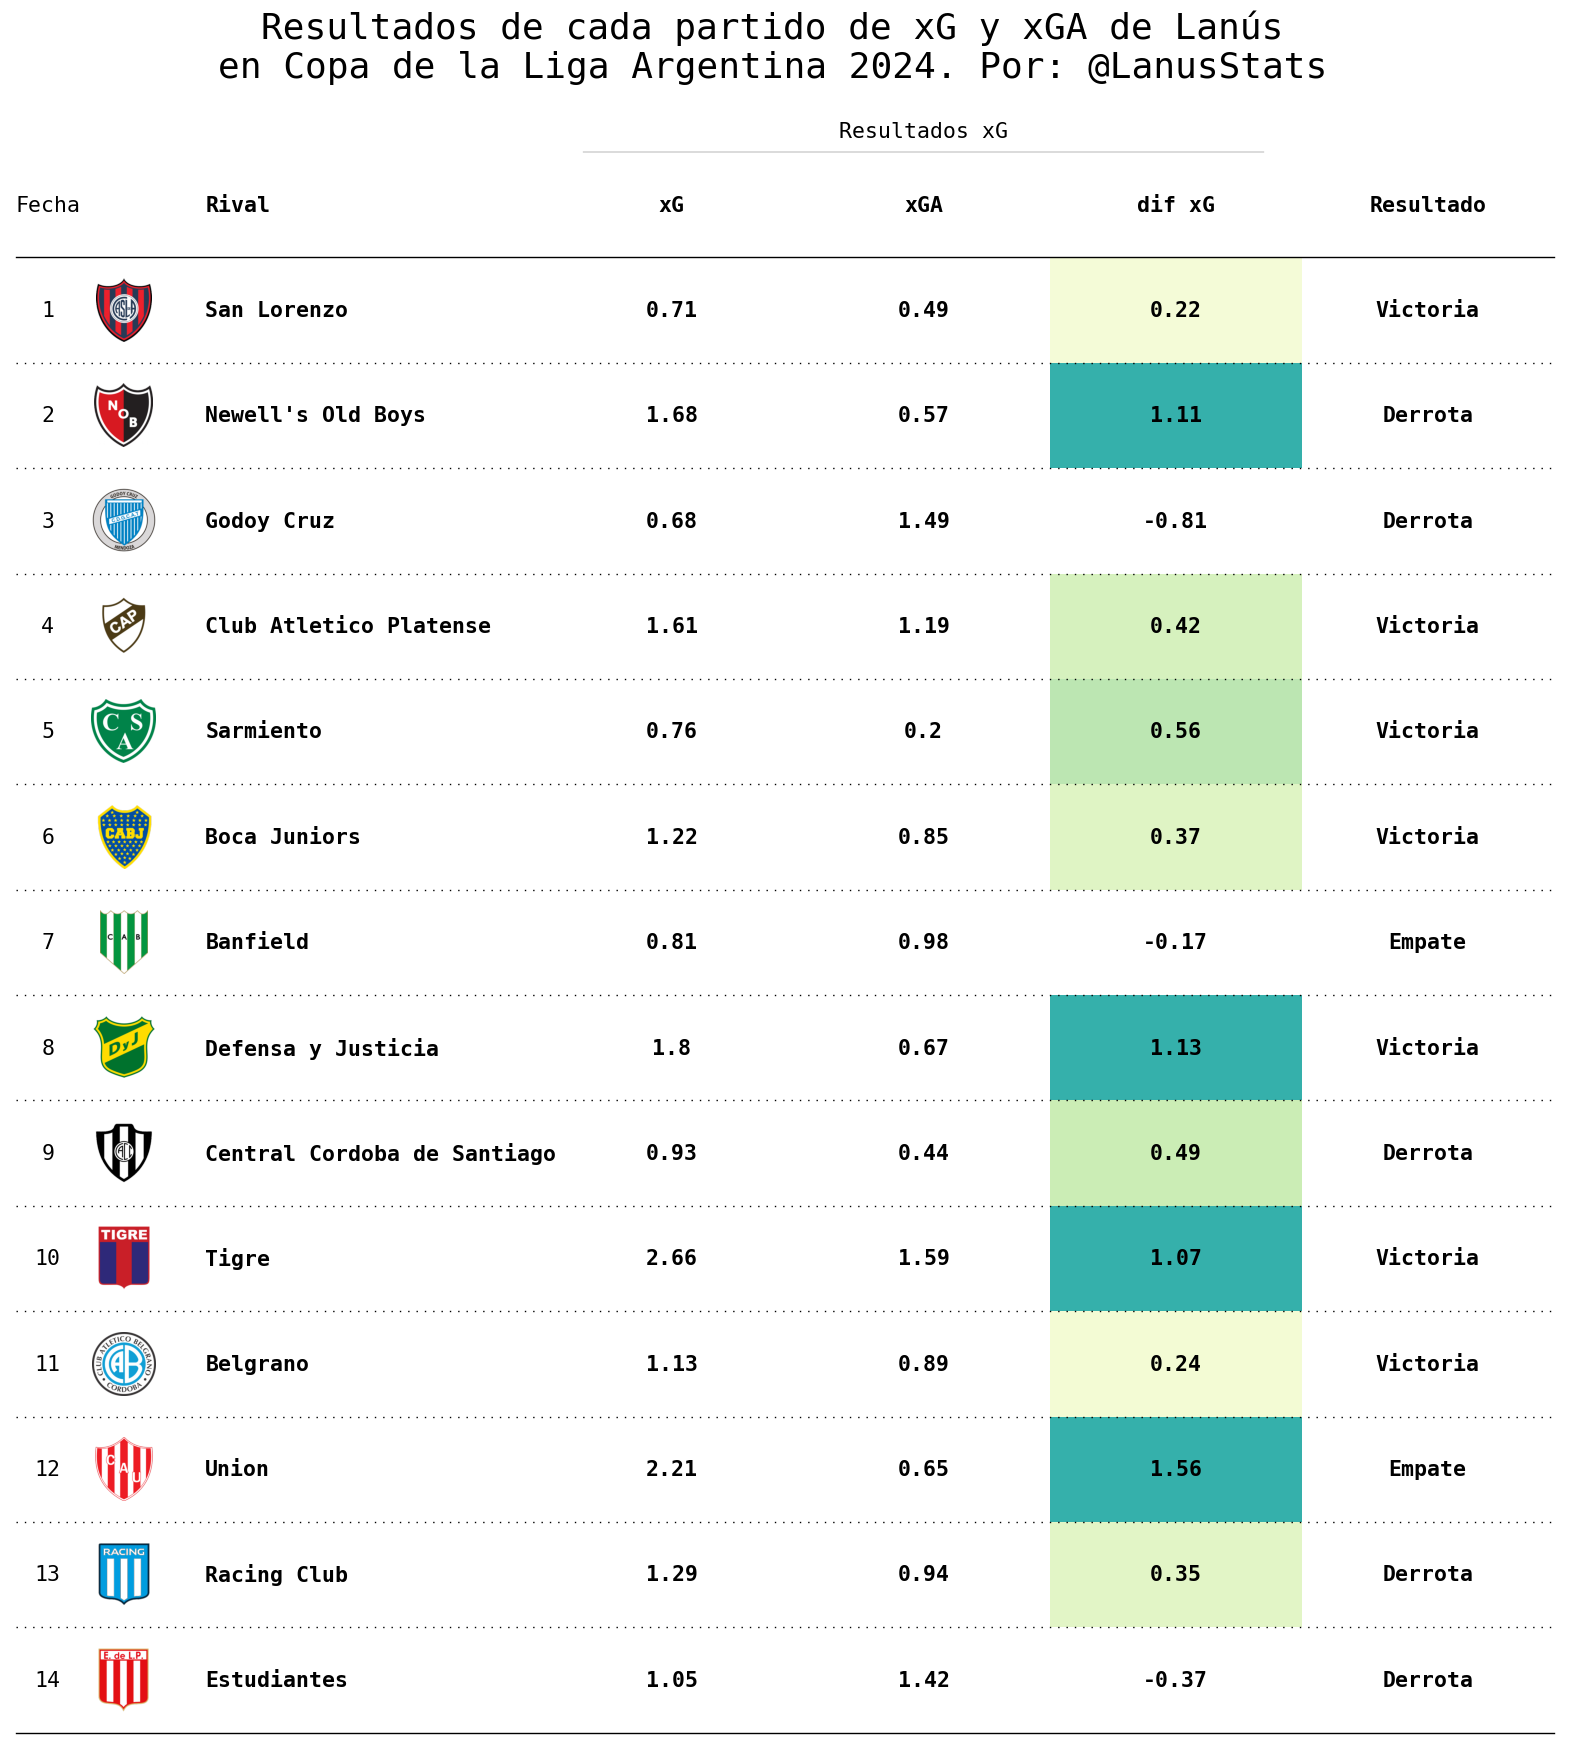

In [87]:

col_defs = [
    ColumnDefinition(
        name="Fecha",
        textprops={"ha": "center"},
        width=0.25,
    ),
    ColumnDefinition(
        name="badge",
        textprops={"ha": "center", "va": "center", 'color': bg_color},
        width=0.35,
        plot_fn=image,
    ),
    ColumnDefinition(
        name="Rival",
        textprops={"ha": "left", "weight": "bold"},
        width=1.5,
    ),
    ColumnDefinition(
        name="xG",
        group="Resultados xG",
        textprops={"ha": "center", "color": "#000000", "weight": "bold"},
        #cmap=normed_cmap(df_plot["% de salir campeon"], cmap=matplotlib.cm.PiYG, num_stds=2)
    ),
    ColumnDefinition(
        name="xGA",
        group="Resultados xG",
        textprops={"ha": "center", "color": "#000000", "weight": "bold"},
    )
    ,
    ColumnDefinition(
        name="dif xG",
        group="Resultados xG",
        textprops={"ha": "center", "color": "#000000", "weight": "bold"},
        cmap=cmap
    )
    ,
    ColumnDefinition(
        name="Resultado",
        textprops={"ha": "center", "color": "#000000", "weight": "bold"},
    )
]
# Ok lets actually create the table
fig, ax = plt.subplots(figsize=(20, 22))
fig.set_facecolor(bg_color)
ax.set_facecolor(bg_color)
table = Table(
    tabla,
    column_definitions=col_defs,
    index_col="Fecha",
    row_dividers=True,
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    footer_divider=True,
    textprops={"fontsize": 15.5},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 1, "linestyle": "-"},
    ax=ax,
)

ax.text(3,-2,'Resultados de cada partido de xG y xGA de Lanús\nen Copa de la Liga Argentina 2024. Por: @LanusStats',ha='center',va='center', size=26)
plt.savefig('C:/Users/Federico Rábanos/Documents/lanus stats/Hilos/CDLG24/tabla resultados_cantidad.png', dpi=300, bbox_inches='tight')

In [94]:
import os
def excel_total(pathCarpeta, torneo):
    files = os.listdir(pathCarpeta)
    df = pd.DataFrame()
    for f in files:
        archivo = f.split('.')
        if archivo[-1] == 'json':
            continue
        else:
            data = pd.read_excel(pathCarpeta+'/'+f, sheet_name='Tiros')
            df = pd.concat([df, data], ignore_index=True)
    #df.to_csv(f'C:/Users/Federico Rábanos/Documents/lanus stats/Python/Todos los eventos {torneo} {fecha}.csv')
    return df

df_tiros = excel_total('C:/Users/Federico Rábanos/Documents/lanus stats/PartidosScraperFC/CopaLPF2024', 'CopaLPF2024')
df = pd.read_csv('C:/Users/Federico Rábanos/Documents/lanus stats/Python/Todos los eventos CopaLPF2024 Fecha 14.csv')

ids_equipos_fotmob = df[['team', 'team_id']].drop_duplicates().reset_index(drop=True)

In [95]:
df_tiros.situation.value_counts()

situation
RegularPlay        3322
FromCorner          766
SetPiece            361
FastBreak           251
FreeKick            210
ThrowInSetPiece      44
Penalty              33
IndividualPlay       26
Name: count, dtype: int64

In [96]:
lista_pelota_parada = ['FromCorner', 'SetPiece', 'FreeKick', 'ThrowInSetPiece']

In [97]:
tiros_pelota_parada = df_tiros[df_tiros['situation'].isin(lista_pelota_parada)]

In [127]:
tiros_pelota_parada[tiros_pelota_parada['eventType'] == 'Goal'].groupby('teamId').x.count()
tiros_pelota_parada[tiros_pelota_parada['expectedGoalsOnTarget'].isna() != True].groupby('teamId').x.count()


teamId
10076     17
10077     11
10078     13
10079     20
10080      8
10081     11
10082     10
10083     13
10084     13
10086      5
10087     14
10089     14
10090      9
10092     12
10094      8
10096     17
10101     13
10103     17
10201     11
10227     15
89396      7
161727    11
161729    12
161730     6
202757     9
213534    12
213596    10
298629     8
Name: x, dtype: int64

In [165]:
stats_pp = tiros_pelota_parada.groupby('teamId')[['expectedGoals']].agg({'expectedGoals': ['count', 'sum']})
stats_pp.columns = stats_pp.columns.droplevel(0)
stats_pp = stats_pp.reset_index().merge(ids_equipos_fotmob, left_on='teamId', right_on='team_id').drop(columns=['teamId']) \
    .merge(tiros_pelota_parada[tiros_pelota_parada['eventType'] == 'Goal'].groupby('teamId').x.count(), left_on='team_id', right_index=True) \
        .merge(tiros_pelota_parada[tiros_pelota_parada['expectedGoalsOnTarget'].isna() != True].groupby('teamId').x.count(), left_on='team_id', right_index=True)
stats_pp = stats_pp.rename(columns={'x_x': 'Goles', 'x_y': 'Tiros al arco', 'count': 'Tiros', 'sum': 'xG generado', 'team': 'Equipo'}).sort_values(by = 'Goles', ascending=False).reset_index(drop=True)
stats_pp['xG generado'] = round(stats_pp['xG generado'],2)
stats_pp['badge'] = stats_pp['Equipo'].apply(
    lambda x: f"C:/Users/Federico Rábanos/Documents/lanus stats/Logos/2/{x.lower().replace('á', 'a').replace('é', 'e').replace('ó', 'o').replace('í', 'i').replace('ú', 'u')}.png"
)

In [169]:
stats_pp = stats_pp[['badge', 'Equipo', 'Goles', 'Tiros', 'Tiros al arco', 'xG generado']]

In [156]:
cmap = LinearSegmentedColormap.from_list(
    name="bugw", colors=["#ffffff", "#f2fbd2", "#c9ecb4", "#93d3ab", "#35b0ab"], N=26
)

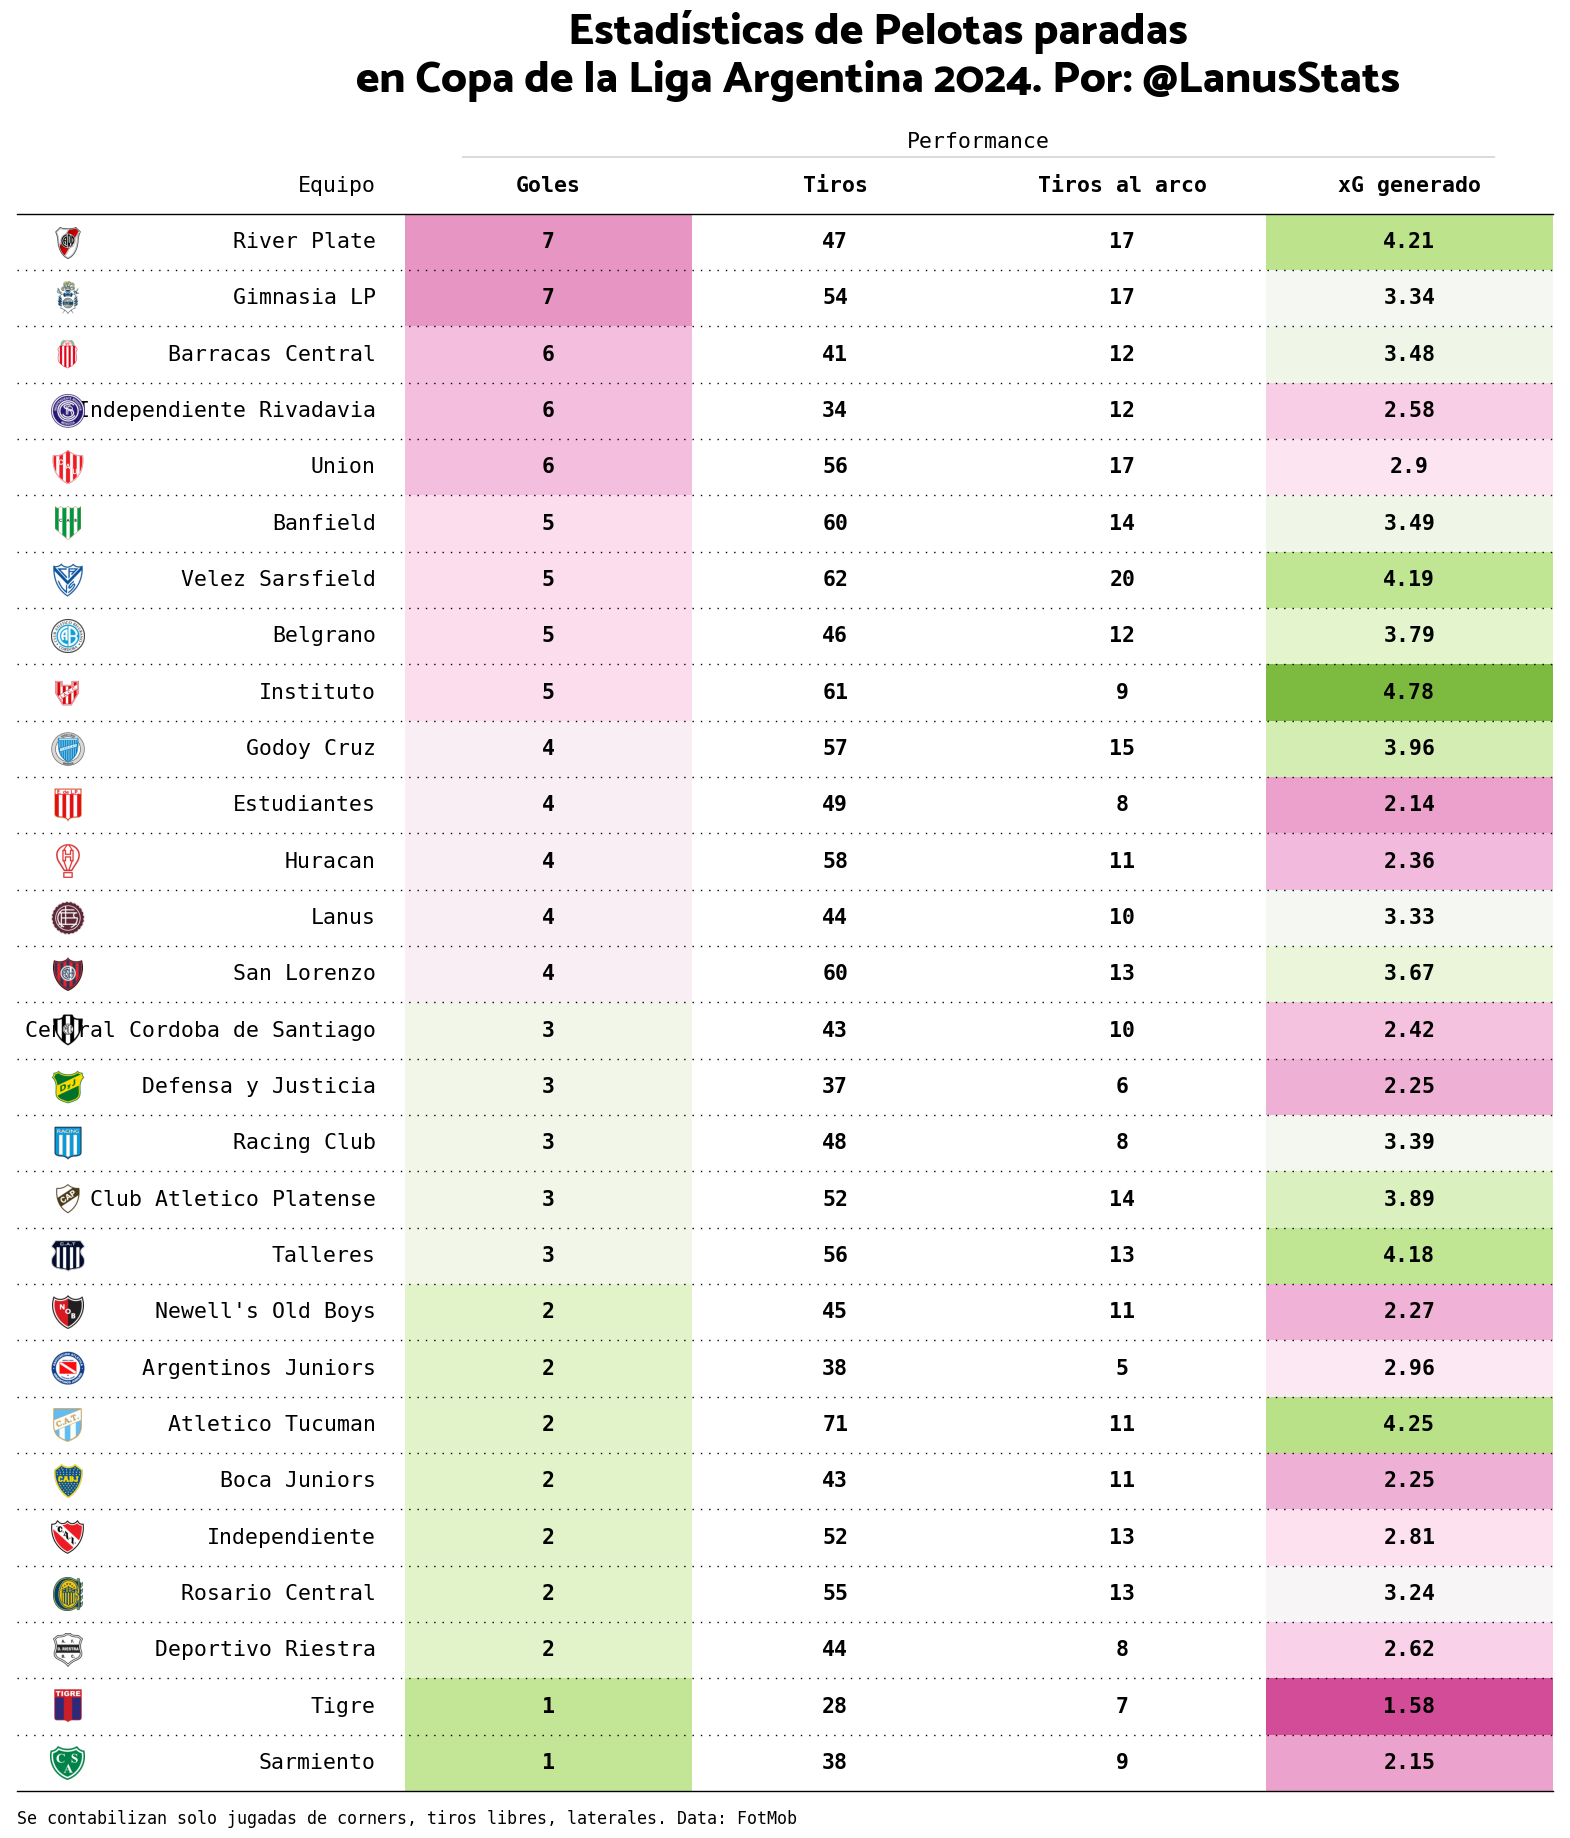

In [178]:
bg_color = "#FFFFFF" # I usually just like to do a white background
text_color = "#000000" # With black text

row_colors = {
    "top4": "#E1FABC",
    "top6": "#FFFC97",
    "relegation": "#E79A9A",
    "even": "#E2E2E1",
    "odd": "#B3B0B0",
}

plt.rcParams["text.color"] = text_color
plt.rcParams["font.family"] = "monospace"

#df_plot['badge'] = df_plot['Equipo'].apply(
#    lambda x: f"C:/Users/Federico Rábanos/Documents/lanus stats/Logos/2/{x.lower().replace('á', 'a').replace('é', 'e').replace('ó', 'o').replace('í', 'i').replace('ú', 'u')}.png"
#)
#df_plot = df_plot.drop(columns=['Unnamed: 0'])
#df_plot['Pos'] = range(1, 29)
col_defs = [
    ColumnDefinition(
        name="badge",
        textprops={"ha": "center", "va": "center", 'color': bg_color},
        width=0.35,
        plot_fn=image,
    ),
    ColumnDefinition(
        name="team",
        textprops={"ha": "left", "weight": "bold"},
        width=1.5,
    ),
    ColumnDefinition(
        name="Goles",
        group="Performance",
        textprops={"ha": "center", "color": "#000000", "weight": "bold"},
        cmap=normed_cmap(stats_pp["Goles"], cmap=matplotlib.cm.PiYG_r, num_stds=4)
    ),
    ColumnDefinition(
        name="Tiros",
        group="Performance",
        textprops={"ha": "center", "color": "#000000", "weight": "bold"},
    )
    ,
    ColumnDefinition(
        name="Tiros al arco",
        group="Performance",
        textprops={"ha": "center", "color": "#000000", "weight": "bold"}
    )
    ,
    ColumnDefinition(
        name="xG generado",
        group="Performance",
        textprops={"ha": "center", "color": "#000000", "weight": "bold"},
        cmap=normed_cmap(stats_pp["xG generado"], cmap=matplotlib.cm.PiYG, num_stds=3)
    )
]
# Ok lets actually create the table
fig, ax = plt.subplots(figsize=(20, 22))
fig.set_facecolor(bg_color)
ax.set_facecolor(bg_color)
table = Table(
    stats_pp,
    column_definitions=col_defs,
    index_col="badge",
    row_dividers=True,
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    footer_divider=True,
    textprops={"fontsize": 15.5},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 1, "linestyle": "-"},
    ax=ax,
)

ax.text(3,-2.8,'Estadísticas de Pelotas paradas\nen Copa de la Liga Argentina 2024. Por: @LanusStats',ha='center',va='center', size=32, fontproperties=catamaran.prop)
ax.text(0,28.5,'Se contabilizan solo jugadas de corners, tiros libres, laterales. Data: FotMob',ha='left',va='center', size=12)
plt.savefig('C:/Users/Federico Rábanos/Documents/lanus stats/Hilos/CDLG24/tabla pp a favor.png', dpi=300, bbox_inches='tight')